In [1]:
#data related imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

# classification model imports
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# deep learning model imports
from keras.callbacks import EarlyStopping
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, LeakyReLU, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.regularizers import l2


#visualizations
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # <-- needed for 3D plotting
from matplotlib.cm import viridis

import seaborn as sns

import time

import joblib



In [3]:
df = pd.read_csv('E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

In [4]:
print(df.isnull().sum())

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64


In [5]:
print(df.duplicated().sum())

814


In [6]:
#because it takes a lot of time to train the svm on the wholedataset. on internet, it was recommended to train it on a shorter dataset and then test it.

df = df.sample(frac=0.35, random_state=42)  # random_state for reproducibility

In [7]:
keep_labels = [
    # if your DDoS attacks are split into multiple subtypes,
    # list them all here, e.g. "DDoS-SYN", "DDoS-UDP", etc…
    "DDoS_HTTP",
    "DDoS_ICMP",
    "DDoS_TCP",
    "DDoS_UDP",
    "Fingerprinting",
    "Port_Scanning",
    "SQL Injection",
    "Vulnerability Scanner",
    "XSS",
    
]

In [8]:
# Drop rows with missing values
df.dropna(inplace=True)
method_encoder = LabelEncoder()

In [9]:
# filter the DataFrame to only those
df = df[df["Attack_type"].isin(keep_labels)].reset_index(drop=True)


In [10]:
len(df.index)

24821

In [11]:



# Fit and transform
df['http.request.method_encoded'] = method_encoder.fit_transform(df['http.request.method'].astype(str))
df['http.request.version_encoded'] = np.where(df['http.request.version'].astype(str).str.strip() == '0', 0, 1)
df['mqtt_topic'] = method_encoder.fit_transform(df['mqtt.topic'].astype(str))
df['mqtt_protoname'] = method_encoder.fit_transform(df['mqtt.protoname'].astype(str))
df['Attack_label'] = np.where(df['Attack_label'].astype(str).str.strip() == 'normal', 0, 1)
df['Attack_type_encoded'] = method_encoder.fit_transform(df['Attack_type'].astype(str))

# Step 1: Drop object columns
X = df.drop(columns=[
    'Attack_type','Attack_type_encoded','Attack_label','http.request.full_uri', 'http.referer', 'http.file_data', 
    'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
    'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
    'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
    'dns.qry.name.len','mqtt.conack.flags'
])

# Step 2: Set target
y = df['Attack_type_encoded']

# Train-val-test split: 80/10/10

# First split: Train 80%, Temp 20%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second split: Validation 10% (1/1 of 20%), Test 10% (1/2 of 20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/2, stratify=y_temp, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [12]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

Train class distribution:
 Attack_type_encoded
3    4072
1    3960
0    2978
5    2881
6    2865
2    2824
4     276
Name: count, dtype: int64
Validation class distribution:
 Attack_type_encoded
3    509
1    495
0    372
5    360
6    358
2    353
4     35
Name: count, dtype: int64
Test class distribution:
 Attack_type_encoded
3    509
1    495
0    373
5    360
6    359
2    353
4     34
Name: count, dtype: int64


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24821 entries, 0 to 24820
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   arp.opcode                    24821 non-null  float64
 1   arp.hw.size                   24821 non-null  float64
 2   icmp.checksum                 24821 non-null  float64
 3   icmp.seq_le                   24821 non-null  float64
 4   icmp.transmit_timestamp       24821 non-null  float64
 5   icmp.unused                   24821 non-null  float64
 6   http.content_length           24821 non-null  float64
 7   http.response                 24821 non-null  float64
 8   http.tls_port                 24821 non-null  float64
 9   tcp.ack                       24821 non-null  float64
 10  tcp.ack_raw                   24821 non-null  float64
 11  tcp.checksum                  24821 non-null  float64
 12  tcp.connection.fin            24821 non-null  float64
 13  t

# One VS Rest Approach Based Support Vector Machine 

In [15]:
from sklearn.svm import SVC
# Train the SVM model
start_time_svm = time.time()

svm = SVC(max_iter=5000, C=1.0, verbose=True)  # Increase max_iter for better convergence
svm.fit(X_train, y_train)

end_time_svm = time.time()

training_duration_svm = end_time_svm - start_time_svm


joblib.dump(svm, 'svm_model_multiclass.joblib')

[LibSVM]

C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


['svm_model_multiclass.joblib']

In [16]:
# Predict
y_pred = svm.predict(X_test)

In [17]:
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print(f"training duration: {training_duration_svm}")

Confusion Matrix:
 [[ 10   0   0 113   0 108 142]
 [  0   0   0 495   0   0   0]
 [ 12   0 191  12   0 126  12]
 [  0   0   0 509   0   0   0]
 [  0   0   0  31   0   2   1]
 [ 15   0 152  63   0 119  11]
 [  6   0   0  54   0 129 170]]

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.03      0.05       373
           1       0.00      0.00      0.00       495
           2       0.56      0.54      0.55       353
           3       0.40      1.00      0.57       509
           4       0.00      0.00      0.00        34
           5       0.25      0.33      0.28       360
           6       0.51      0.47      0.49       359

    accuracy                           0.40      2483
   macro avg       0.28      0.34      0.28      2483
weighted avg       0.30      0.40      0.31      2483


Accuracy Score: 0.4023358840112767
training duration: 21.686134576797485


C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)



In [19]:
# Define colormap (supports up to 10 classes)
base_cmap = plt.cm.get_cmap('tab10')
num_classes = len(np.unique(y_test))
class_colors = base_cmap(np.linspace(0, 1, num_classes))

C:\Users\afnan\AppData\Local\Temp\ipykernel_4468\3148507636.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('tab10')


In [20]:
# Refit on the original labels
method_encoder.fit(df['Attack_type'].astype(str))

# Display mapping
for i, label in enumerate(method_encoder.classes_):
    print(f"{i}: {label}")

0: DDoS_HTTP
1: DDoS_ICMP
2: DDoS_TCP
3: DDoS_UDP
4: Fingerprinting
5: Port_Scanning
6: XSS


In [21]:
print(df[['Attack_type_encoded']].head(10))

   Attack_type_encoded
0                    1
1                    5
2                    3
3                    2
4                    6
5                    1
6                    2
7                    6
8                    6
9                    2


In [22]:
# Convert from one-hot to class indices
# y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
# zy_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred


true_colors = np.array([class_colors[int(c)] for c in y_test])
pred_colors = np.array([class_colors[int(c)] for c in y_pred])

wrong_mask = (y_pred != y_test)
pred_colors[wrong_mask] = np.array([1, 0, 0, 1])  # red for wrong preds


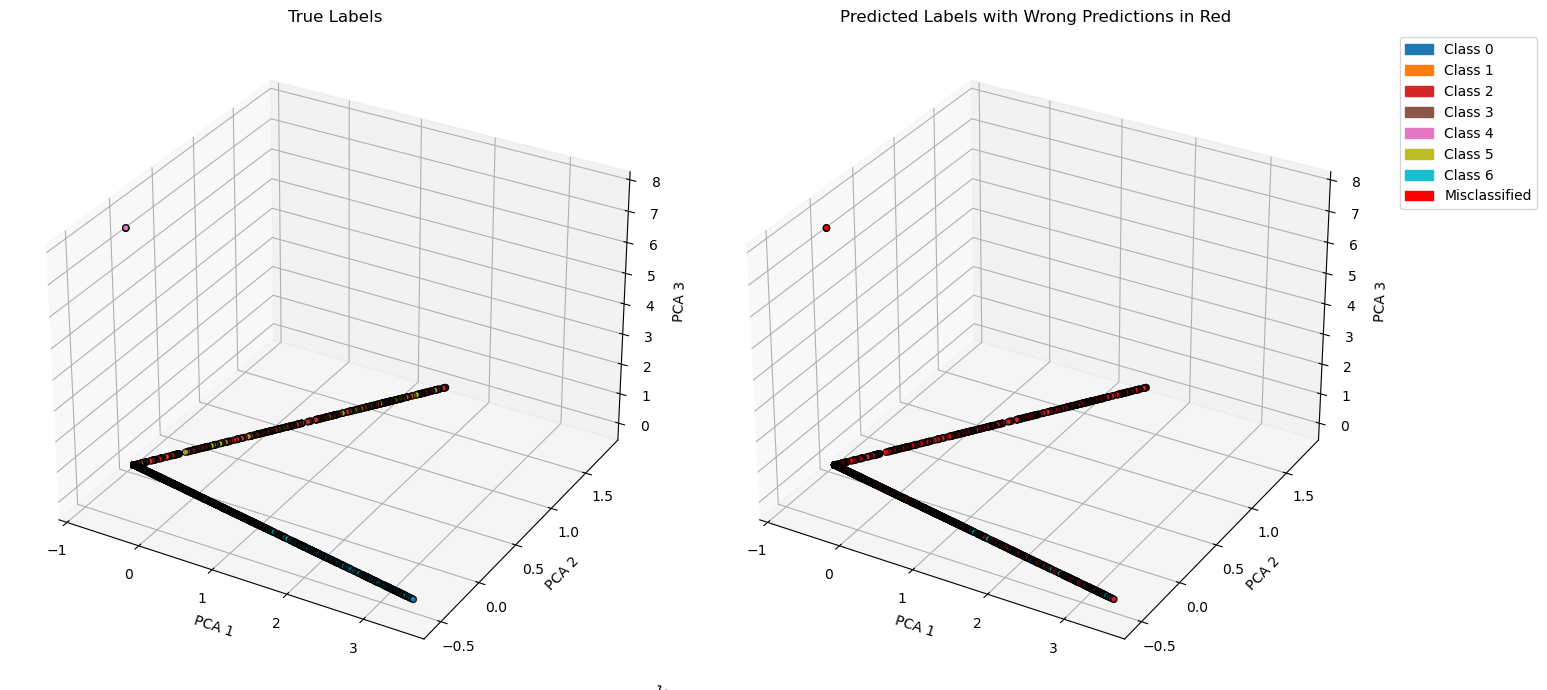

In [23]:
import matplotlib.patches as mpatches

# Plot side by side
fig = plt.figure(figsize=(16,7))

# True labels plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=true_colors, alpha=0.8, edgecolor='k')
ax1.set_title("True Labels")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_zlabel("PCA 3")

# Predicted labels plot with red wrong preds
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=pred_colors, alpha=0.8, edgecolor='k')
ax2.set_title("Predicted Labels with Wrong Predictions in Red")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")


# --- Legends ---
class_patches = [mpatches.Patch(color=class_colors[i], label=f'Class {i}') for i in range(num_classes)]
class_patches.append(mpatches.Patch(color='red', label='Misclassified'))

ax2.legend(handles=class_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

# decision tree classifier

In [24]:
num_classes = len(np.unique(y_train))


model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',       # Use softmax for multiclass
    num_class=num_classes,
    eval_metric='mlogloss'          # Evaluation metric
)

# Start timer
start_time = time.time()

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True  # Optional: shows training log
)

# End timer
end_time = time.time()

model.save_model("xgb_model.json")


[0]	validation_0-mlogloss:1.63068
[1]	validation_0-mlogloss:1.40938
[2]	validation_0-mlogloss:1.23977
[3]	validation_0-mlogloss:1.09577
[4]	validation_0-mlogloss:0.98428
[5]	validation_0-mlogloss:0.88138
[6]	validation_0-mlogloss:0.79286
[7]	validation_0-mlogloss:0.71705
[8]	validation_0-mlogloss:0.65428
[9]	validation_0-mlogloss:0.59529
[10]	validation_0-mlogloss:0.54363
[11]	validation_0-mlogloss:0.49753
[12]	validation_0-mlogloss:0.45579
[13]	validation_0-mlogloss:0.41943
[14]	validation_0-mlogloss:0.38629
[15]	validation_0-mlogloss:0.35579
[16]	validation_0-mlogloss:0.32810
[17]	validation_0-mlogloss:0.30315
[18]	validation_0-mlogloss:0.28095
[19]	validation_0-mlogloss:0.25977
[20]	validation_0-mlogloss:0.24155
[21]	validation_0-mlogloss:0.22515
[22]	validation_0-mlogloss:0.20977
[23]	validation_0-mlogloss:0.19651
[24]	validation_0-mlogloss:0.18334
[25]	validation_0-mlogloss:0.17137
[26]	validation_0-mlogloss:0.16043
[27]	validation_0-mlogloss:0.15090
[28]	validation_0-mlogloss:0.1

In [25]:
# Predict
y_pred = model.predict(X_test)

# Accuracy
print(f"\n✅ Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Test Accuracy: 0.9851

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       373
           1       0.99      0.99      0.99       495
           2       1.00      1.00      1.00       353
           3       1.00      1.00      1.00       509
           4       0.85      0.82      0.84        34
           5       0.99      1.00      0.99       360
           6       0.99      0.94      0.97       359

    accuracy                           0.99      2483
   macro avg       0.97      0.96      0.96      2483
weighted avg       0.99      0.99      0.99      2483



In [26]:
training_duration_dt = end_time - start_time
print(f"training duration: {training_duration_dt}")

training duration: 3.4492850303649902


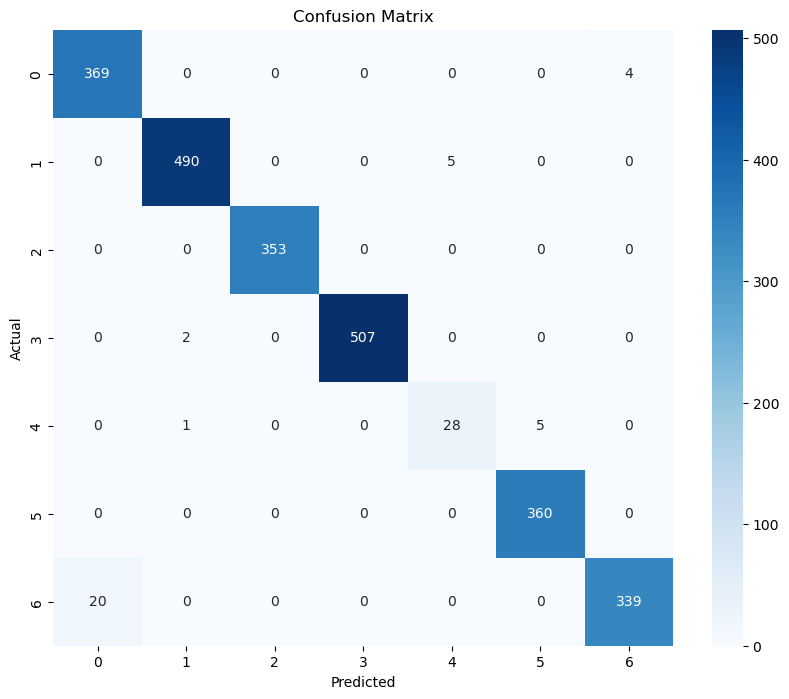

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\afnan\AppData\Local\Temp\ipykernel_4468\3193504519.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_classes))


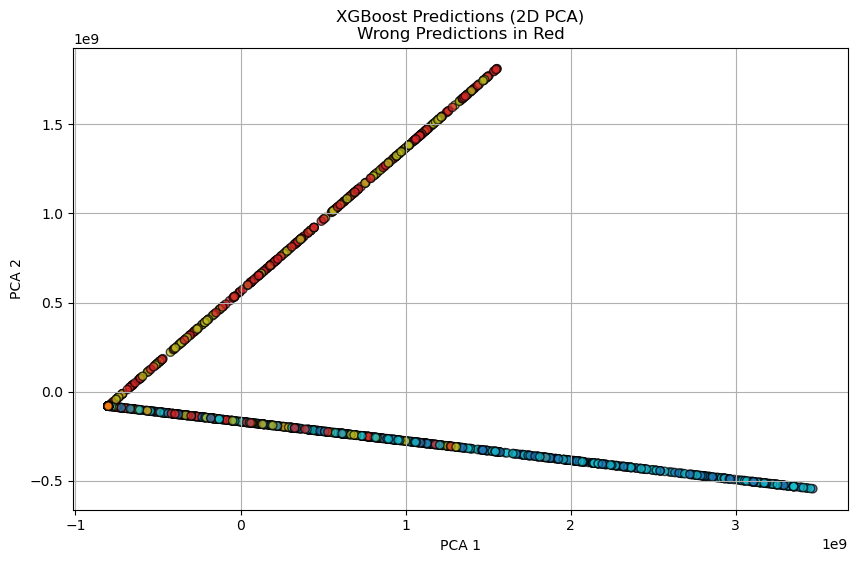

In [28]:
# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Convert one-hot labels if necessary
y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
y_pred = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

# Build a colormap
unique_classes = np.unique(y_test)
cmap = plt.cm.get_cmap("tab10", len(unique_classes))
colors = [cmap(i) for i in y_test]

# Wrong predictions in red
wrong = y_pred != y_test
colors = [cmap(c) if not wrong[i] else (1, 0, 0, 1) for i, c in enumerate(y_pred)]

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, edgecolor='k', alpha=0.7)
plt.title("XGBoost Predictions (2D PCA)\nWrong Predictions in Red")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Dataset for Deep Learning Models

In [2]:
df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


C:\Users\afnan\AppData\Local\Temp\ipykernel_22272\2820990379.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


In [3]:
df_fnn.isnull().sum()

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64

In [4]:
keep_labels = [
    # if your DDoS attacks are split into multiple subtypes,
    # list them all here, e.g. "DDoS-SYN", "DDoS-UDP", etc…
    "DDoS_HTTP",
    "DDoS_ICMP",
    "DDoS_TCP",
    "DDoS_UDP",
    "Fingerprinting",
    "Port_Scanning",
    "SQL Injection",
    "Vulnerability Scanner",
    "XSS",
    
]

# filter the DataFrame to only those
df_fnn = df_fnn[df_fnn["Attack_type"].isin(keep_labels)].reset_index(drop=True)

In [5]:
    # Drop rows with missing values
    # df_fnn.dropna(inplace=True)

    #encoding important columns
    # Initialize encoder
    method_encoder = LabelEncoder()

    # Fit and transform
    df_fnn['http.request.method_encoded'] = method_encoder.fit_transform(df_fnn['http.request.method'].astype(str))
    df_fnn['http.request.version_encoded'] = np.where(df_fnn['http.request.version'].astype(str).str.strip() == '0', 0, 1)
    df_fnn['mqtt_topic'] = method_encoder.fit_transform(df_fnn['mqtt.topic'].astype(str))
    df_fnn['mqtt_protoname'] = method_encoder.fit_transform(df_fnn['mqtt.protoname'].astype(str))
    df_fnn['Attack_label'] = np.where(df_fnn['Attack_label'].astype(str).str.strip() == 'normal', 0, 1)
    df_fnn['Attack_type_encoded'] = method_encoder.fit_transform(df_fnn['Attack_type'].astype(str))

    # Step 2: Set target
    y_fnn = df_fnn['Attack_type_encoded']

    # Now drop object and unnecessary columns
    X_fnn = df_fnn.drop(columns=[
        'Attack_type', 'Attack_type_encoded', 'Attack_label', 'http.request.full_uri', 'http.referer', 'http.file_data', 
        'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
        'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
        'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
        'dns.qry.name.len','mqtt.conack.flags'
    ])

In [6]:
# Refit on the original labels
method_encoder.fit(df_fnn['Attack_type'].astype(str))

# Display mapping
for i, label in enumerate(method_encoder.classes_):
    print(f"{i}: {label}")

0: DDoS_HTTP
1: DDoS_ICMP
2: DDoS_TCP
3: DDoS_UDP
4: Fingerprinting
5: Port_Scanning
6: XSS


In [7]:

# First split: Train 80%, Temp 20%
X_train_fnn, X_temp_fnn, y_train_fnn, y_temp_fnn = train_test_split(
    X_fnn, y_fnn, test_size=0.2, stratify=y_fnn, random_state=42
)

# Second split: Validation 10% (1/2 of 20%), Test 10% (1/2 of 20%)
X_val_fnn, X_test_fnn, y_val_fnn, y_test_fnn = train_test_split(
    X_temp_fnn, y_temp_fnn, test_size=1/2, stratify=y_temp_fnn, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train_fnn = X_train_fnn.reset_index(drop=True)
X_val_fnn = X_val_fnn.reset_index(drop=True)
X_test_fnn = X_test_fnn.reset_index(drop=True)

y_train_fnn = y_train_fnn.reset_index(drop=True)
y_val_fnn = y_val_fnn.reset_index(drop=True)
y_test_fnn = y_test_fnn.reset_index(drop=True)


In [8]:
overlap = set(map(tuple, X_train_fnn.values)) & set(map(tuple, X_val_fnn.values))
print(f"Train/Val Overlap: {len(overlap)}")  # Should be 0

Train/Val Overlap: 6735


In [9]:
print("Train class distribution:\n", y_train_fnn.value_counts())
print("Validation class distribution:\n", y_val_fnn.value_counts())
print("Test class distribution:\n", y_test_fnn.value_counts())

Train class distribution:
 Attack_type_encoded
3    97254
1    93149
2    40049
0    39929
5    18051
6    12732
4      801
Name: count, dtype: int64
Validation class distribution:
 Attack_type_encoded
3    12157
1    11643
2     5007
0     4991
5     2256
6     1592
4      100
Name: count, dtype: int64
Test class distribution:
 Attack_type_encoded
3    12157
1    11644
2     5006
0     4991
5     2257
6     1591
4      100
Name: count, dtype: int64


In [10]:
df_fnn['Attack_type_encoded'].value_counts()

Attack_type_encoded
3    121568
1    116436
2     50062
0     49911
5     22564
6     15915
4      1001
Name: count, dtype: int64

In [11]:
print(df_fnn[['Attack_label']].head(10))

   Attack_label
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1


# Feed Forward Neural Network

In [38]:

# Define the model
def build_fnn_model(input_size,num_classes):
    model = Sequential()
    model.add(Dense(45, input_dim=input_size,name="Hidden_Layer_1"))  
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
#     model.add(Dense(32, input_dim=input_size, kernel_regularizer=l2(0.001)))
#     model.add(LeakyReLU(alpha=0.01))
#     model.add(Dropout(0.2))
    model.add(Dense(16, input_dim=input_size,name="Hidden_Layer_2"))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes,activation="softmax",name="Output_layer")) # No sigmoid here if using BCEWithLogitsLoss
    return model


In [39]:
#normalize the data
scaler = StandardScaler()
X_train_fnn = scaler.fit_transform(X_train_fnn)
X_val_fnn = scaler.transform(X_val_fnn)
X_test_fnn = scaler.transform(X_test_fnn)


# convert dataframe to numpy arrays
y_train_tensor_fnn = y_train_fnn.to_numpy()
y_val_tensor_fnn = y_val_fnn.to_numpy()
y_test_tensor_fnn = y_test_fnn.to_numpy()

# --- One-hot encode the labels for multi-class classification ---
y_train_tensor_fnn = to_categorical(y_train_tensor_fnn)
y_val_tensor_fnn = to_categorical(y_val_tensor_fnn)
y_test_tensor_fnn = to_categorical(y_test_tensor_fnn)




In [40]:
num_classes = y_train_tensor_fnn.shape[1]
# Start timer
start_time_fnn = time.time()

# Build model
input_size = X_train_fnn.shape[1]
model = build_fnn_model(input_size,num_classes)


# Use categorical_crossentropy for multi-class classification
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)               │ (None, 45)                  │           2,070 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 45)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 16)                  │             736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_layer (Dense)                 │ (None, 7)                   │             119 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,925 (11.43 KB)

 Trainable params: 2,925 (11.43 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:

history = model.fit(
    X_train_fnn, y_train_tensor_fnn,
    validation_data=(X_val_fnn, y_val_tensor_fnn),
    epochs=15,
    batch_size=32,
    shuffle=True,
#     callbacks=None,
#     class_weight=None,
    verbose=1
)


# End timer
end_time_fnn = time.time()



# Duration
training_duration_fnn = end_time_fnn - start_time_fnn

print(f"⏱️ Model trained in {training_duration_fnn:.2f} seconds")


Epoch 1/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.8925 - loss: 0.3135 - val_accuracy: 0.9609 - val_loss: 0.0990
Epoch 2/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9549 - loss: 0.1140 - val_accuracy: 0.9636 - val_loss: 0.0873
Epoch 3/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9583 - loss: 0.1043 - val_accuracy: 0.9645 - val_loss: 0.0881
Epoch 4/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9600 - loss: 0.0993 - val_accuracy: 0.9671 - val_loss: 0.0811
Epoch 5/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9610 - loss: 0.0964 - val_accuracy: 0.9655 - val_loss: 0.0845
Epoch 6/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9618 - loss: 0.0954 - val_accuracy: 0.9660 - val_loss: 0.0803
Epoch 7/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.9626 - loss: 0.0937 - val_accuracy: 0.9695 - val_loss: 0.0787
Epoch 8/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9626 - loss: 0

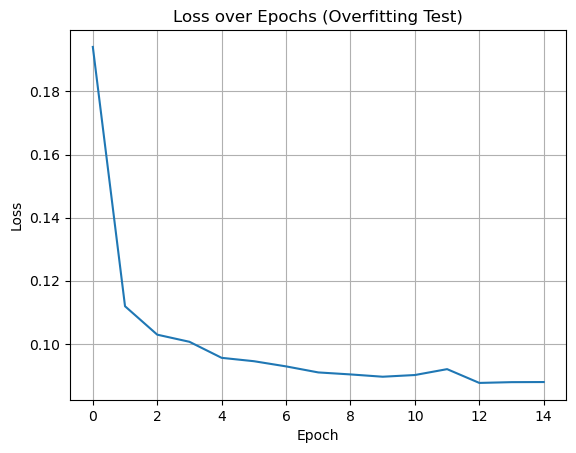

In [42]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [43]:
# Evaluate
loss, accuracy = model.evaluate(X_test_fnn, y_test_tensor_fnn, verbose=1)
print(f"\n🧪 Test Accuracy: {accuracy:.4f}")


1180/1180 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0708

🧪 Test Accuracy: 0.9717


In [44]:
# Predict on test data
y_pred_probs = model.predict(X_test_fnn)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_tensor_fnn, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes))

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4991
           1       1.00      1.00      1.00     11644
           2       1.00      0.94      0.97      5006
           3       1.00      1.00      1.00     12157
           4       1.00      0.28      0.44       100
           5       0.87      1.00      0.93      2257
           6       0.80      0.78      0.79      1591

    accuracy                           0.97     37746
   macro avg       0.94      0.85      0.86     37746
weighted avg       0.97      0.97      0.97     37746



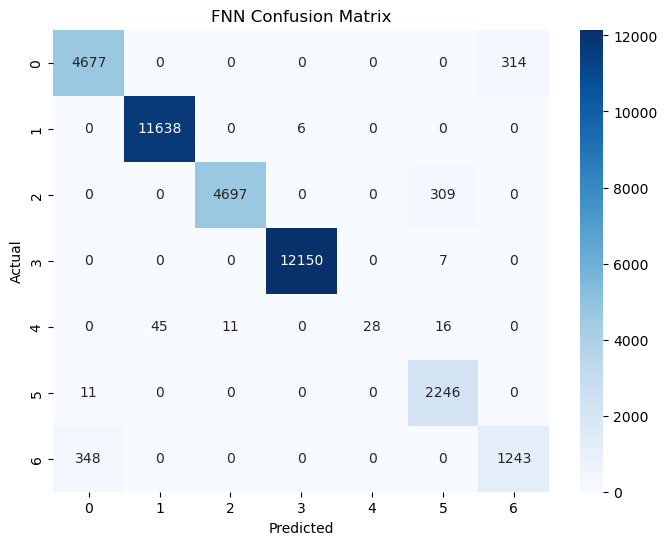

In [45]:
import seaborn as sns
# Plot confusion matrix

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("FNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [46]:
# Save the model
model.save("fnn_model_tf.h5")

# Convolutional Neural Network

In [11]:
# Convert to numpy arrays
X_train = X_train_fnn.to_numpy()
X_val = X_val_fnn.to_numpy()
X_test = X_test_fnn.to_numpy()

y_train = y_train_fnn.to_numpy()
y_val = y_val_fnn.to_numpy()
y_test = y_test_fnn.to_numpy()

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


# One-hot encode labels
y_train_cnn = to_categorical(y_train)
y_val_cnn = to_categorical(y_val)
y_test_cnn = to_categorical(y_test)


In [12]:
num_classes = y_train_cnn.shape[1]
# Build CNN model
model = Sequential([
    Conv1D(45, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:

# Train model
start_time_cnn = time.time()

history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=15,
    batch_size=32,
#     shuffle=True,
#     callbacks=None,
#     class_weight=None,
    verbose=1
)
end_time_cnn = time.time()

training_duration_cnn = end_time_cnn - start_time_cnn

print(f"⏱️ Model trained in {training_duration_cnn:.2f} seconds")


Epoch 1/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.9051 - loss: 0.2667 - val_accuracy: 0.9642 - val_loss: 0.0929
Epoch 2/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9563 - loss: 0.1054 - val_accuracy: 0.9646 - val_loss: 0.0857
Epoch 3/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.9596 - loss: 0.0970 - val_accuracy: 0.9614 - val_loss: 0.0891
Epoch 4/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9618 - loss: 0.0925 - val_accuracy: 0.9663 - val_loss: 0.0829
Epoch 5/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9626 - loss: 0.0904 - val_accuracy: 0.9669 - val_loss: 0.0790
Epoch 6/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9642 - loss: 0.0868 - val_accuracy: 0.9659 - val_loss: 0.0786
Epoch 7/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9647 - loss: 0.0864 - val_accuracy: 0.9669 - val_loss: 0.0785
Epoch 8/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9657 - loss: 0

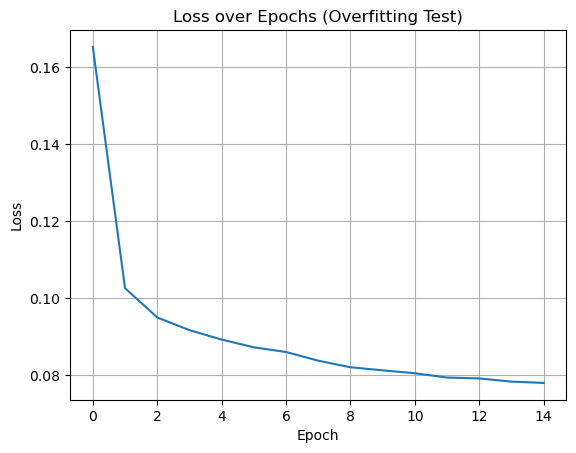

In [14]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [15]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9722 - loss: 0.0662

Test Accuracy: 0.9726
Test Loss: 0.0658


In [16]:
# Predict
y_pred_probs = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4991
           1       1.00      1.00      1.00     11644
           2       1.00      0.94      0.97      5006
           3       1.00      1.00      1.00     12157
           4       0.64      0.49      0.55       100
           5       0.86      1.00      0.92      2257
           6       0.78      0.87      0.82      1591

    accuracy                           0.97     37746
   macro avg       0.89      0.89      0.89     37746
weighted avg       0.97      0.97      0.97     37746



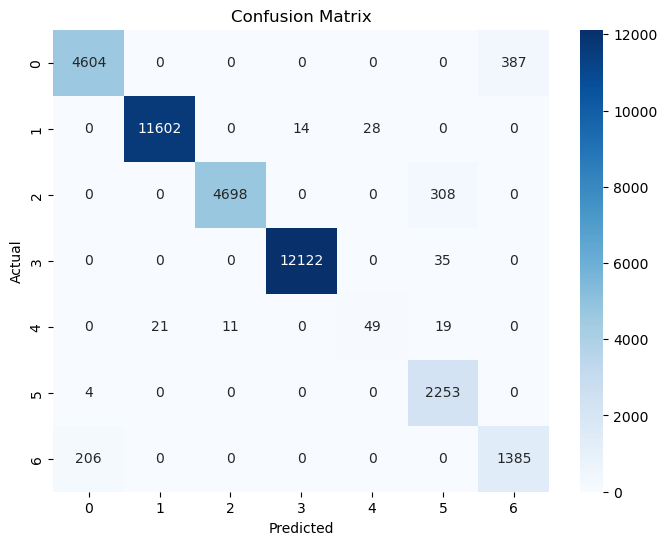

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

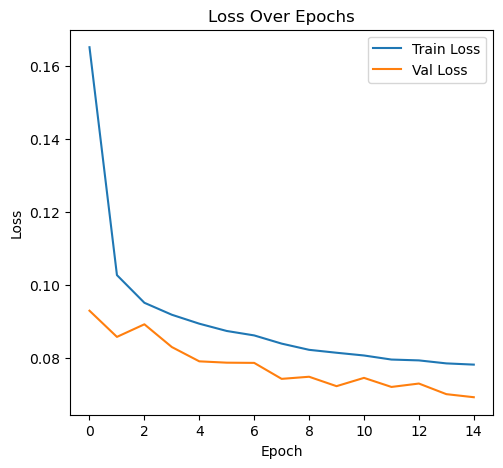

In [18]:
# Plot training/validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [19]:
# Save the model to an HDF5 file
model.save("cnn_model.h5")

# Long Short Term Memory


In [12]:
timesteps = 1

num_features = X_train_fnn.shape[1]

# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_fnn = X_train_fnn.to_numpy()
y_train_lstm = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_fnn = X_val_fnn.to_numpy()
y_val_lstm = y_val_fnn.to_numpy().reshape(-1, 1)

X_test_fnn = X_test_fnn.to_numpy()  # Convert to numpy array
y_test_lstm = y_test_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_fnn)
X_val_scaled = scaler.transform(X_val_fnn)  # use transform only on val
X_test_scaled = scaler.transform(X_test_fnn)  # use transform only on val



X_train_lstm = X_train_scaled.reshape(-1, timesteps, num_features)
X_val_lstm = X_val_scaled.reshape(-1, timesteps, num_features)
X_test_lstm = X_test_scaled.reshape(-1, timesteps, num_features)

y_train_lstm = to_categorical(y_train_fnn)
y_val_lstm = to_categorical(y_val_fnn)
y_test_lstm = to_categorical(y_test_fnn)

In [13]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True , input_shape=(timesteps,num_features), activation='tanh'))
model.add(LSTM(units = 64, activation = 'tanh', return_sequences = True))
model.add(LSTM(units = 32, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          89,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,945 (589.63 KB)

 Trainable params: 150,945 (589.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
num_classes = y_train_lstm.shape[1]

# ---------- 2. Define LSTM model ----------
model = Sequential()
model.add(LSTM(45, return_sequences=True, activation='relu', input_shape=(timesteps, num_features))) 
model.add(Dropout(0.2))


model.add(Dense(16))
model.add(ReLU())

model.add(LSTM(8, return_sequences=False)) 
model.add(Dropout(0.2))

model.add(ReLU())


model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 1, 45)               │          16,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 45)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 16)               │             736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,979 (70.23 KB)

 Trainable params: 17,979 (70.23 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Step 5: Train
start_time_lstm = time.time()
history = model.fit(
    X_train_lstm, 
    y_train_lstm,                
    validation_data=(X_val_lstm, y_val_lstm), #validation dataset
    epochs=15,
    batch_size=32,
#     callbacks=None,
#     shuffle=True,
#     class_weight=None,
    verbose=1
)
end_time_lstm = time.time()
training_duration_lstm = end_time_lstm - start_time_lstm
print(f"training duration is: {training_duration_lstm}")

Epoch 1/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7593 - loss: 0.6802 - val_accuracy: 0.9025 - val_loss: 0.2267
Epoch 2/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8781 - loss: 0.3180 - val_accuracy: 0.9597 - val_loss: 0.1350
Epoch 3/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9252 - loss: 0.2182 - val_accuracy: 0.9600 - val_loss: 0.1232
Epoch 4/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9284 - loss: 0.2018 - val_accuracy: 0.9596 - val_loss: 0.1215
Epoch 5/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9284 - loss: 0.1979 - val_accuracy: 0.9626 - val_loss: 0.1179
Epoch 6/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9337 - loss: 0.1892 - val_accuracy: 0.9590 - val_loss: 0.1166
Epoch 7/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9320 - loss: 0.1893 - val_accuracy: 0.9630 - val_loss: 0.1134
Epoch 8/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9340 - loss: 0

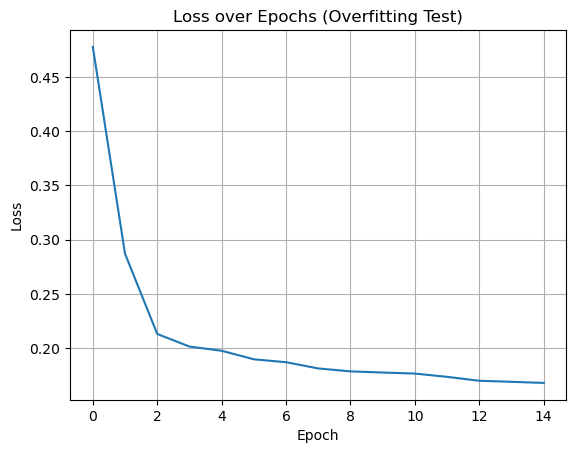

In [16]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [17]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities
y_pred_prob = model.predict(X_test_lstm)

# Get predicted classes (argmax of softmax output)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true classes (from one-hot encoded labels)
y_true = np.argmax(y_test_lstm, axis=1)



1180/1180 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9626 - loss: 0.1035
Test Loss: 0.1037
Test Accuracy: 0.9618
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [18]:

# Print classification report

print(classification_report(y_test_lstm, y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [19]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

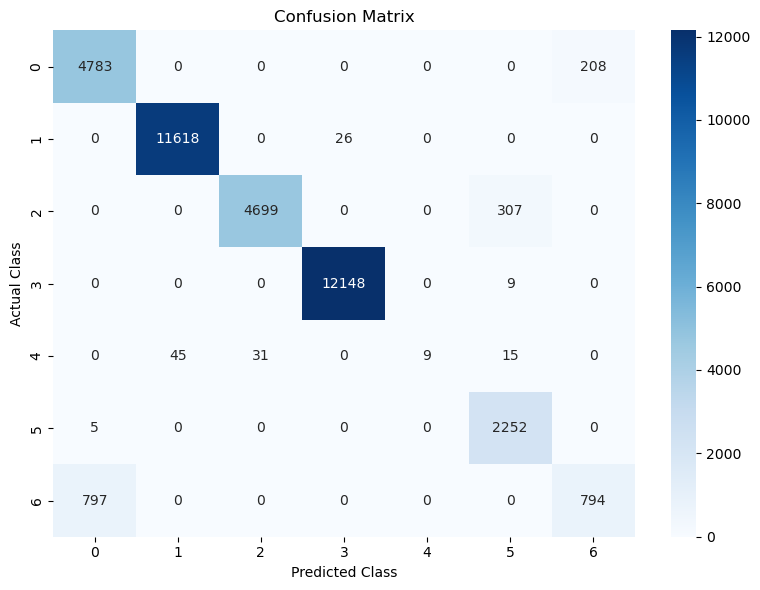

In [20]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.show()

In [21]:
model.save("lstm_edge_model.h5")

In [ ]:
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_test_np shape:", y_test_np.shape)
print("X_test_lstm dtype:", X_test_lstm.dtype)
print("y_test_np dtype:", y_test_np.dtype)

# CNN + LSTM Hybrid


In [12]:
timesteps = 10
total_features = X_train_fnn.shape[1]

remainder = total_features % timesteps  # 6
padding_size = timesteps - remainder  # 4

num_features = (total_features + padding_size) // timesteps  # 50 // 10 = 5

input_shape = (timesteps, num_features)



# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_hybrid = X_train_fnn.to_numpy()
y_train_hybrid = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_hybrid = X_val_fnn.to_numpy()
y_val_hybrid = y_val_fnn.to_numpy().reshape(-1, 1)

X_test_hybrid = X_test_fnn.to_numpy()
y_test_hybrid = y_test_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled_hybrid = scaler.fit_transform(X_train_hybrid)
X_val_scaled_hybrid = scaler.transform(X_val_hybrid)  # use transform only on val
X_test_scaled_hybrid = scaler.transform(X_test_hybrid)

#padding so that its evenly divided

X_train_padded = np.pad(
    X_train_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)
X_val_padded = np.pad(
    X_val_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)

X_test_padded = np.pad(
    X_test_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)


X_train_hybrid = X_train_padded.reshape(-1, timesteps, num_features)
X_val_hybrid = X_val_padded.reshape(-1, timesteps, num_features)
X_test_hybrid = X_test_padded.reshape(-1, timesteps, num_features)

y_train_hybrid = to_categorical(y_train_fnn)
y_val_hybrid = to_categorical(y_val_fnn)
y_test_hybrid = to_categorical(y_test_fnn)



In [13]:
num_classes = y_train_hybrid.shape[1]

def cnn_lstm_gru_model(input_shape):
    model = Sequential([
        Conv1D(45, 3, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(2),
        Dropout(0.2),

        Conv1D(64, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(2),
        Dropout(0.2),

        LSTM(24, return_sequences=False),

#         Dense(16, activation='relu',kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
model = cnn_lstm_gru_model(input_shape)
model.summary()

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 10, 45)              │             720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 45)              │             180 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 10, 45)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 45)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 45)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5, 64)               │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 24)                  │           8,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,579 (72.57 KB)

 Trainable params: 18,361 (71.72 KB)

 Non-trainable params: 218 (872.00 B)

In [15]:
train_start_time_hybrid = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(
    X_train_hybrid,
    y_train_hybrid,
    validation_data=(X_val_hybrid, y_val_hybrid),
    epochs=15,
    batch_size=32,
    verbose = 1
#     callbacks=[early_stop],
#     shuffle=True,
#     class_weight=None,
)
# Record the ending time
train_end_time_hybrid = time.time()


# Evaluate the model
loss, accuracy = model.evaluate(X_test_hybrid, y_test_hybrid, batch_size=32)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time_hybrid = train_end_time_hybrid - train_start_time_hybrid
print(f"Training time: {train_time_hybrid:.2f} seconds")


Epoch 1/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9038 - loss: 0.2636 - val_accuracy: 0.9573 - val_loss: 0.1022
Epoch 2/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.9586 - loss: 0.1081 - val_accuracy: 0.9628 - val_loss: 0.0867
Epoch 3/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.9616 - loss: 0.0968 - val_accuracy: 0.9654 - val_loss: 0.0807
Epoch 4/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9631 - loss: 0.0943 - val_accuracy: 0.9653 - val_loss: 0.0810
Epoch 5/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - accuracy: 0.9640 - loss: 0.0914 - val_accuracy: 0.9665 - val_loss: 0.0810
Epoch 6/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - accuracy: 0.9648 - loss: 0.0888 - val_accuracy: 0.9673 - val_loss: 0.0787
Epoch 7/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9655 - loss: 0.0881 - val_accuracy: 0.9680 - val_loss: 0.0778
Epoch 8/15
9437/9437 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - accuracy: 0.9651 - loss: 0

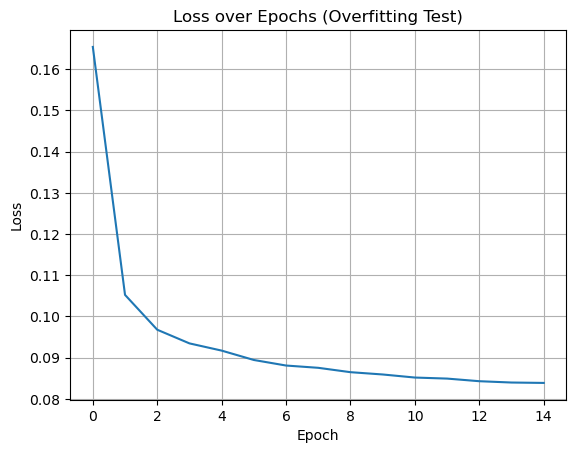

In [16]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

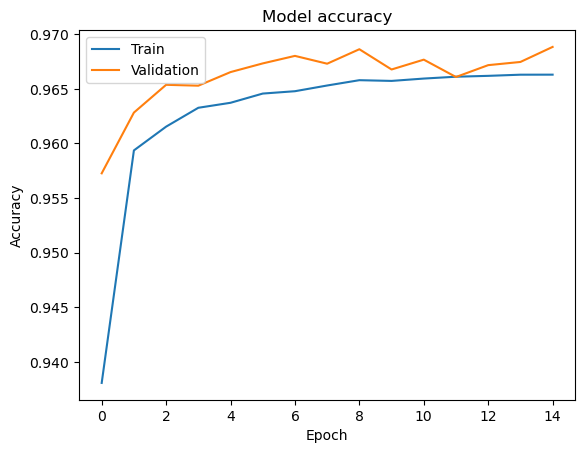

In [17]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


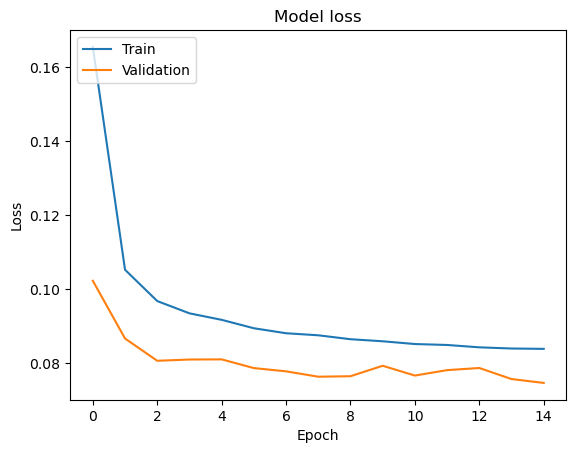

In [18]:

# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_hybrid, y_test_hybrid, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Predict class probabilities
y_pred_prob = model.predict(X_test_hybrid)

# Get predicted classes (argmax of softmax output)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true classes (from one-hot encoded labels)
y_true = np.argmax(y_test_hybrid, axis=1)

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9710 - loss: 0.0716
Test Loss: 0.0715
Test Accuracy: 0.9710
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [20]:
# Print classification report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      4991
           1       1.00      0.99      1.00     11644
           2       1.00      0.94      0.97      5006
           3       0.99      1.00      1.00     12157
           4       1.00      0.28      0.44       100
           5       0.87      1.00      0.93      2257
           6       0.77      0.88      0.82      1591

    accuracy                           0.97     37746
   macro avg       0.94      0.86      0.87     37746
weighted avg       0.97      0.97      0.97     37746



In [21]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

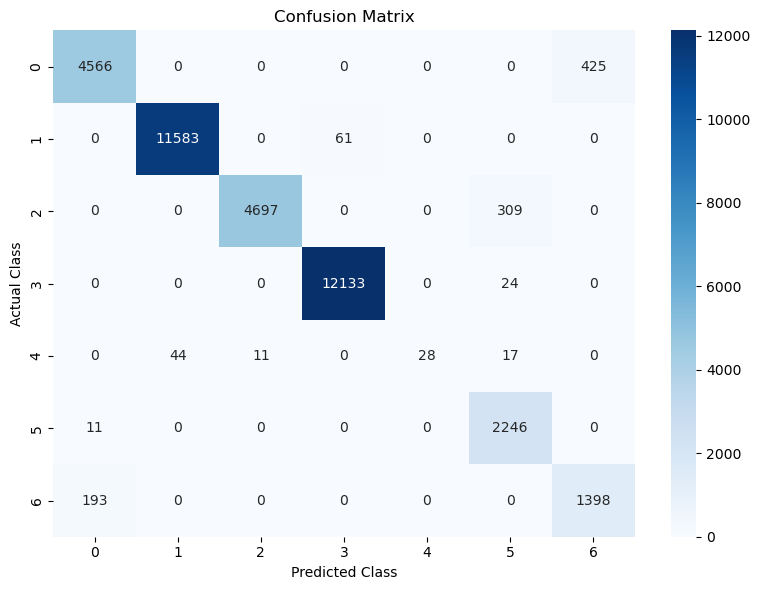

In [22]:
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.show()

In [23]:
model.save("cnn_lstm_hybrid_model.h5")